In [57]:
import os
import re
import sys
from os import listdir
from os.path import isfile, join
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np

from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [58]:
p_dir = (Path().cwd().parents[0]).absolute()

In [59]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import affine
import transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import tof-sims data

In [60]:
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def get_imgs_SIMS(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
        fov = f[name].attrs["fov"]
    return imgs, labels, fov


def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale


def get_NN(data, n):
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    distances, indices = fit.kneighbors(data)

    return distances, indices


def filter_img_knn(img, n=25, th=3.5):
    # Get avg distances per positive expressed pixels
    x, y = np.where(img > 0)
    values = img[x, y]

    data = np.column_stack((x, y))
    distances, indices = get_NN(data, n)
    # avg_dist = np.average(distances, axis=1, weights=values[indices])
    avg_dist = np.average(distances, axis=1)

    filter_ind = avg_dist > th
    unique, counts = np.unique(filter_ind, return_counts=True)
    print(unique, counts)
    x_fil = x[filter_ind]
    y_fil = y[filter_ind]

    img_fil = img.copy()
    img_fil[x_fil, y_fil] = 0

    return img_fil

In [101]:
core = "L11"
datasets = [core + "_1", core + "_2", core + "_3"]
# datasets = [core + "_1"]
experiment = "endometrium"

imgs_nuclei_downscale = []
fovs = []
# fov_add = [72,72,72] #L72
# fov_add = [72,65,54] #L128
fov_add = [65,65,65] #L11

for i, name in enumerate(datasets):
    try:
        imgs, labels, fov = get_imgs_SIMS(experiment, name)
    except:
        continue
    print(fov)
    fov = int(fov) + fov_add[i]
    img_nuclei_downscale = get_imgs_index(imgs, [18, 32], fov_dim=fov)
    p2, p98 = np.percentile(img_nuclei_downscale, (10, 99.99))
    img_nuclei_downscale = exposure.rescale_intensity(
        img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 255)
    )
    img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)
    imgs_nuclei_downscale.append(img_nuclei_downscale)
    fovs.append(fov)

378.9063
378.9063
378.9063


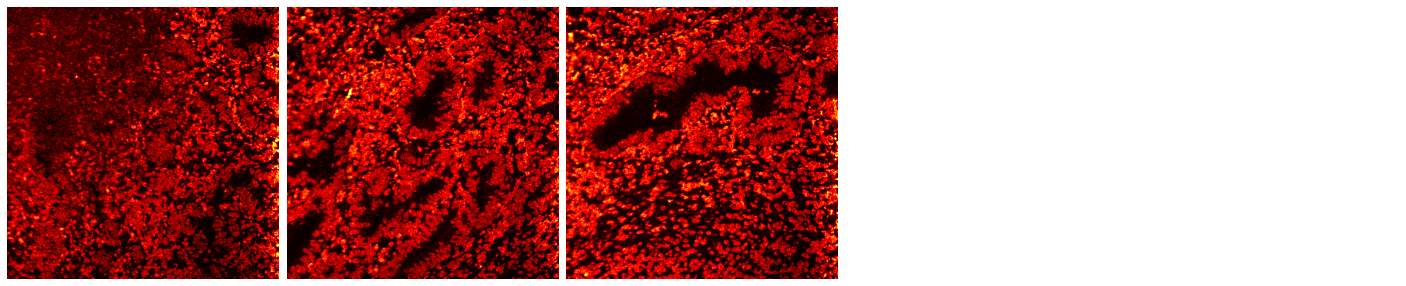

In [102]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax = ax.flatten()
for i in range(len(ax)):
    try:
        ax[i].imshow(imgs_nuclei_downscale[i], cmap="hot")
    except:
        pass
    ax[i].axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

# Import IMC data 

In [ ]:
from skimage.transform import rotate
import cv2

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (10, 95))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale

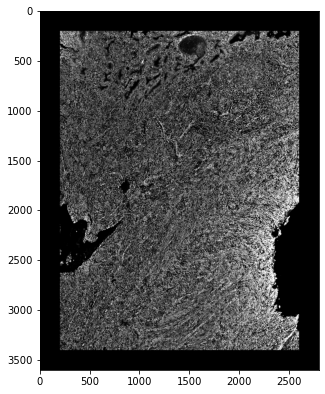

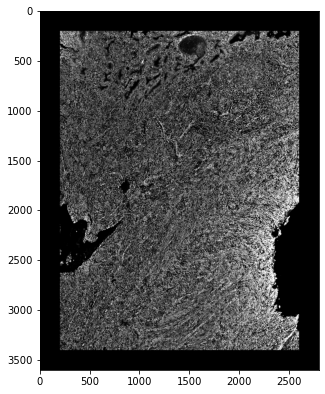

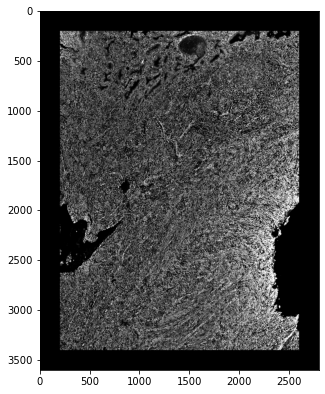

In [105]:
imgs_h3 = []

for dataset in datasets:
    # imgs, markers = get_imgs(dataset, "IMC")
    imgs, markers = get_imgs(core, "IMC")
    subset = ["DNA1", "DNA2"]

    img_dapi = np.sum(imgs[[markers.index(marker) for marker in subset]], axis=0)
    img_dapi = contrast_stretching(img_dapi)
    
    border = 200
    rotation = -90

    img_h3 = rotate(img_dapi, rotation, resize=True)
    img_h3 = img_as_ubyte(img_h3)
    img_h3 = cv2.copyMakeBorder(img_h3, border, border, border, border, cv2.BORDER_CONSTANT, None, value = 0)

    fig, ax = plt.subplots(figsize=(5, 20))
    ax.imshow(img_h3, cmap="gray")
    plt.show()
    
    imgs_h3.append(img_h3)

# Template matching between IMC and Tof-sims data

## Match template 

In [106]:
from typing import Tuple

from skimage.feature import match_template
from skimage.transform import rescale


def match_region(
    source: np.ndarray, template: np.ndarray, show: bool = True, path=None
) -> Tuple[np.ndarray, Tuple[int, int, int, int]]:
    """
    Template matching between source and template
    Return cropped source matching template and bbox of crop region
    """

    # Use template matching
    result = match_template(source, template)

    # Get maximum point of correlation
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    h_region, w_region = template.shape
    
    if show:
        # Plot result
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(source, cmap=plt.cm.gray)
        ax.set_axis_off()

        # highlight matched region
        rect = plt.Rectangle(
            (x, y), w_region, h_region, edgecolor="r", facecolor="none", lw=3
        )
        ax.add_patch(rect)

    img_crop = source[y : y + h_region, x : x + w_region]

    return img_crop, (y, h_region, x, w_region)

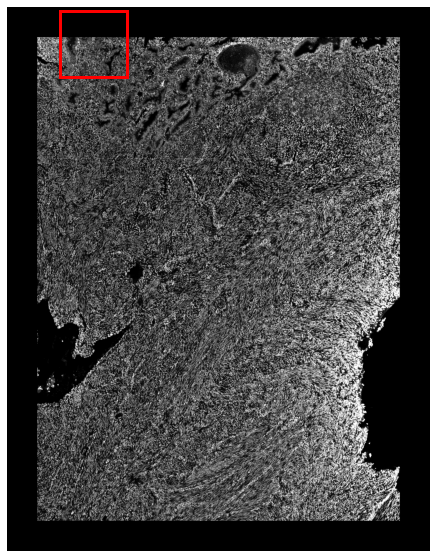

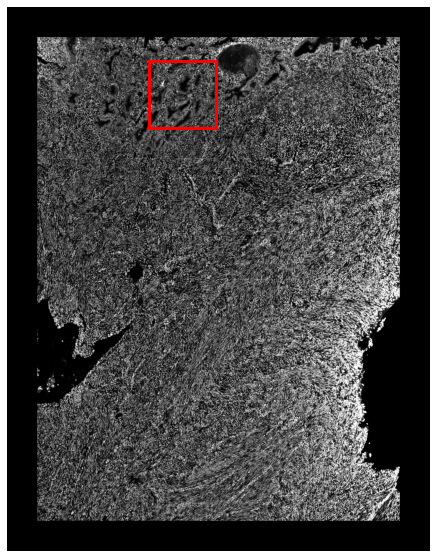

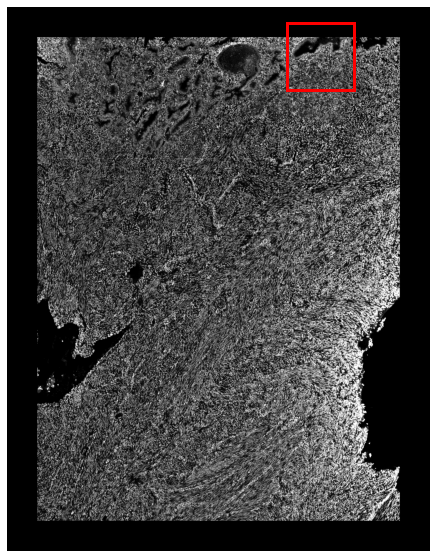

In [107]:
imgs_h3_crop, bbox = map(
    list, zip(*[match_region(img_h3, img) for img_h3, img in zip(imgs_h3, imgs_nuclei_downscale)])
)
plt.show()

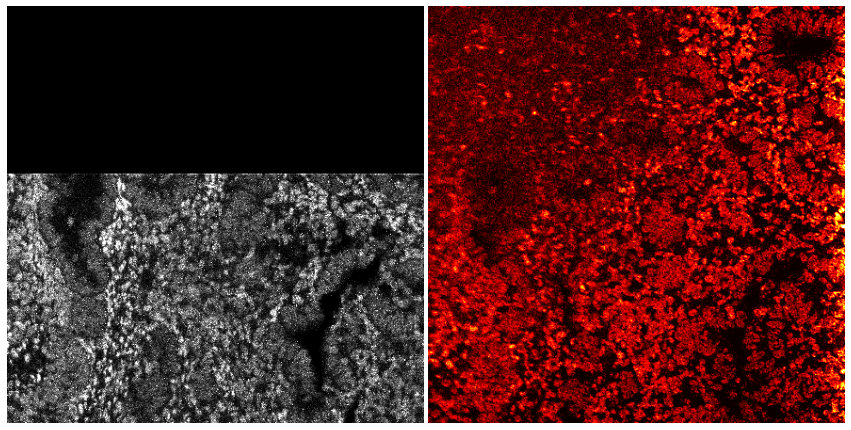

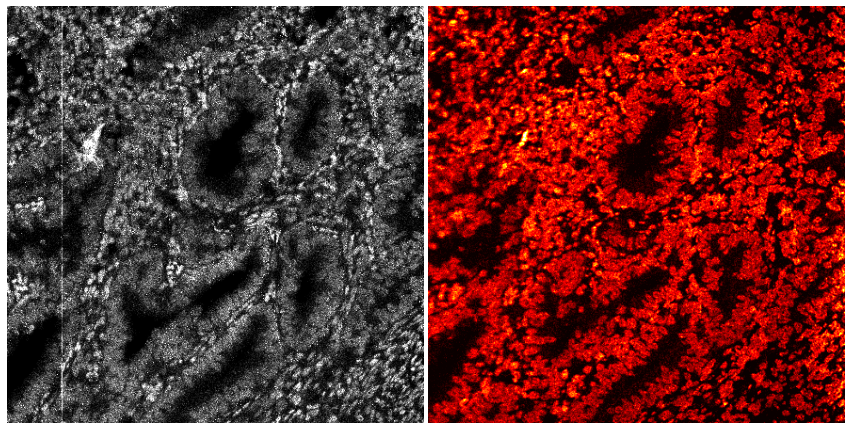

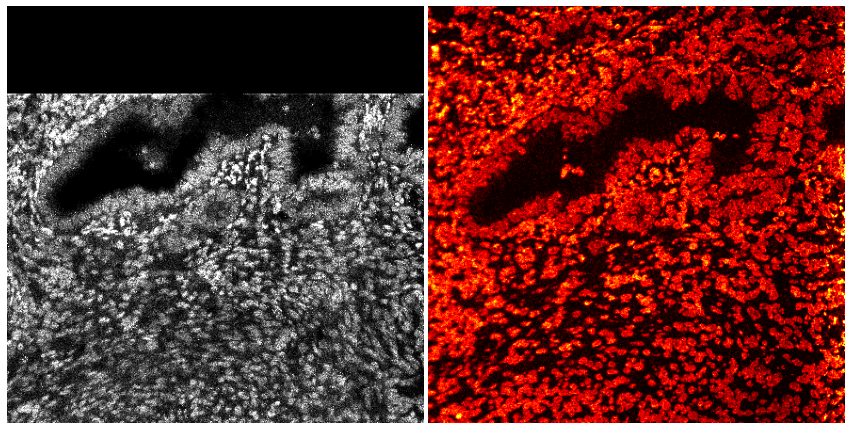

In [108]:
for i in range(len(imgs_h3_crop)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(imgs_h3_crop[i], cmap="gray")
    ax[1].imshow(imgs_nuclei_downscale[i], cmap="hot")
    ax[0].axis("off")
    ax[1].axis("off")
    fig.subplots_adjust(wspace=0.01)
    plt.show()

## Calculate rotation

In [109]:
from skimage.registration import phase_cross_correlation
from skimage.transform import rescale, rotate, warp_polar


def get_rotation(source: np.ndarray, template: np.ndarray, radius: int = 720) -> int:
    """
    Calculate rotation angle between source and template in degrees
    """

    image_polar = warp_polar(source, radius=radius)
    rotated_polar = warp_polar(template, radius=radius)

    shifts, error, phasediff = phase_cross_correlation(
        image_polar, rotated_polar, upsample_factor=10
    )
    print("Recovered value for counterclockwise rotation: " f"{shifts[0]}")

    return shifts[0]

In [110]:
rotations = [
    get_rotation(img1, img2) for img1, img2 in zip(imgs_h3_crop, imgs_nuclei_downscale)
]
mean_rotation = np.mean(rotations)

Recovered value for counterclockwise rotation: 0.2
Recovered value for counterclockwise rotation: 0.2
Recovered value for counterclockwise rotation: 0.5


In [111]:
imgs_h3_r_crop = []
bboxs_r = []

for i, img in enumerate(imgs_nuclei_downscale):
    res, bbox_r = match_region(rotate(imgs_h3[i], rotations[i], resize=True), img, show=False)
    imgs_h3_r_crop.append(res)
    bboxs_r.append(bbox_r)

# Affine transform

Getting key points


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 4611 key points
MOVING image: found 2740 key points
MATCHED points: found 1510 matched points
Getting key points
FIXED image: found 4268 key points
MOVING image: found 4582 key points
MATCHED points: found 3284 matched points
Getting key points
FIXED image: found 4002 key points
MOVING image: found 3361 key points
MATCHED points: found 3154 matched points


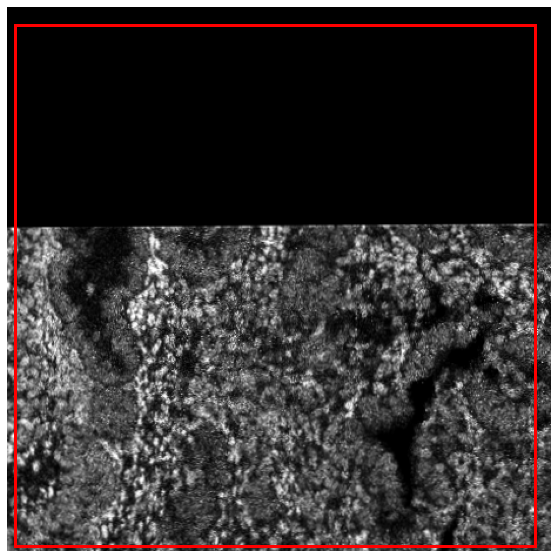

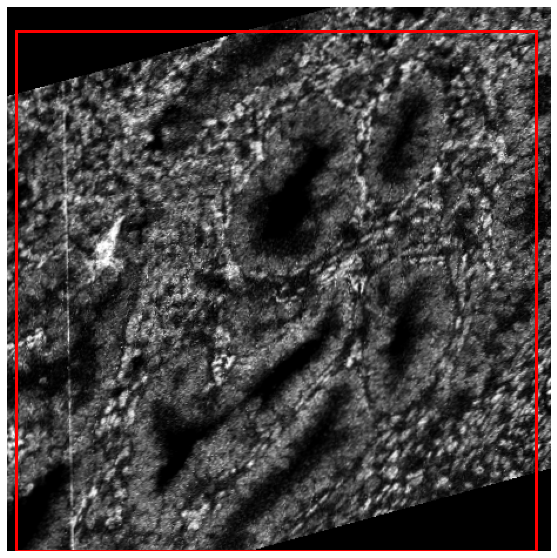

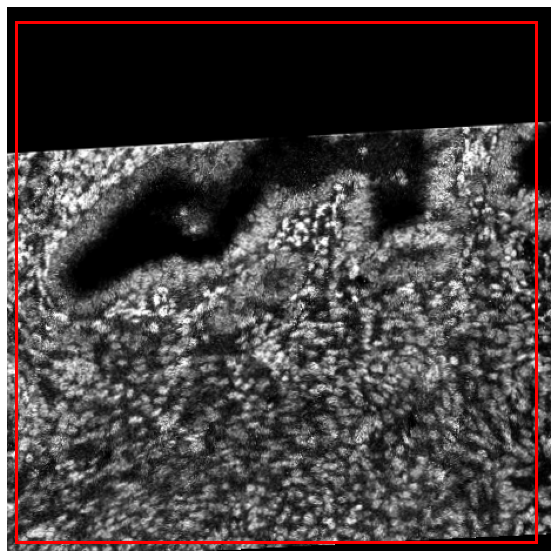

In [119]:
min_radius = 3
max_radius = 9
match_threshold=0.4
pad = 10

imgs_h3_r_t_crop = []
bboxs_r_t = []
affs = []

for i, img in enumerate(imgs_nuclei_downscale):
    img2 = img_as_ubyte(imgs_h3_r_crop[i])
    img1 = img_as_ubyte(img)
    img_h3_rotate = rotate(imgs_h3[i], rotations[i], resize=True)
    
    # Get affine transformation 
    aff = affine.ransac_affine(img1, img2, min_radius, max_radius, match_threshold)
    
#     # Affine transform on whole field of view
#     imgs_h3_aligned = transform.apply_global_affine(img_h3_rotate, img_h3_rotate, aff)
#     res, bbox_r = match_region(imgs_h3_aligned, img1, show=False)
    
    # Affine transform on crop
    res2 = transform.apply_global_affine(img2, img2, aff)
    
    # Affine transform on enlarged crop then match
    y, h_region, x, w_region = bboxs_r[i]
    y = y - pad
    h_region = h_region + 2*pad
    x = x - pad
    w_region = w_region + 2*pad
    y = 0 if y < 0 else y
    x = 0 if x < 0 else x
    img3 = img_h3_rotate[y : y + h_region, x : x + w_region]
    img3_aligned = transform.apply_global_affine(img3, img3, aff)
    res3, bbox_r = match_region(img3_aligned, img1, show=True)
    
    imgs_h3_r_t_crop.append(res3)
    bboxs_r_t.append(bbox_r)
    affs.append(aff)
    

In [120]:
import napari
i = 0

viewer = napari.view_image(imgs_h3_r_t_crop[i])
viewer.add_image(imgs_nuclei_downscale[i])

<Image layer 'Image [1]' at 0x1b4c8532b80>

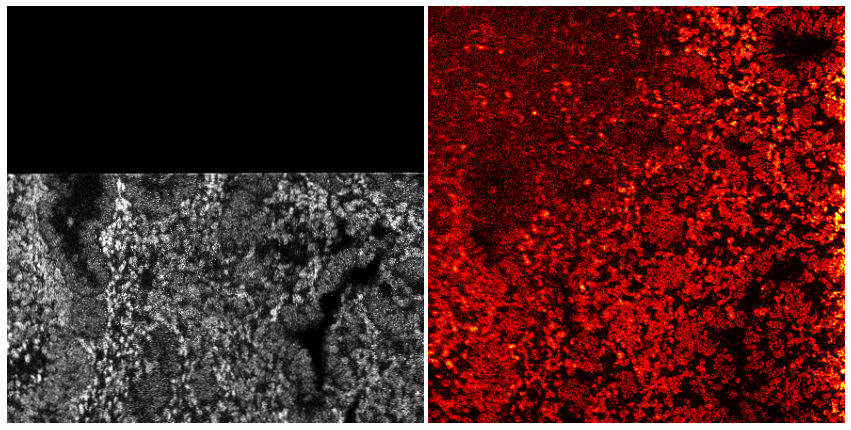

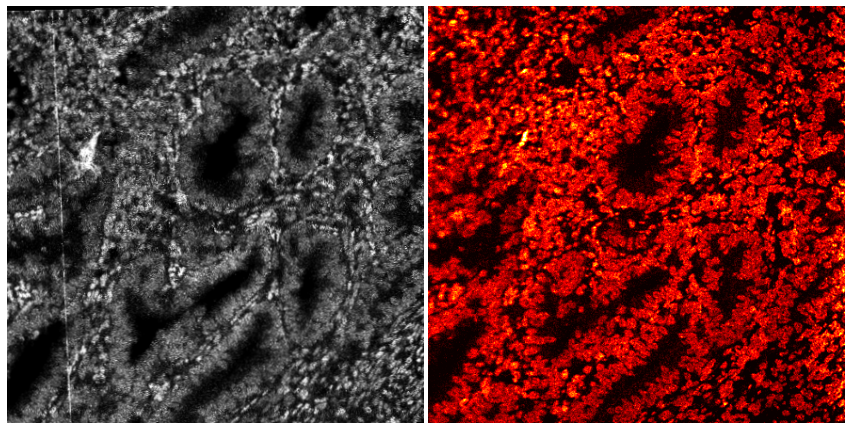

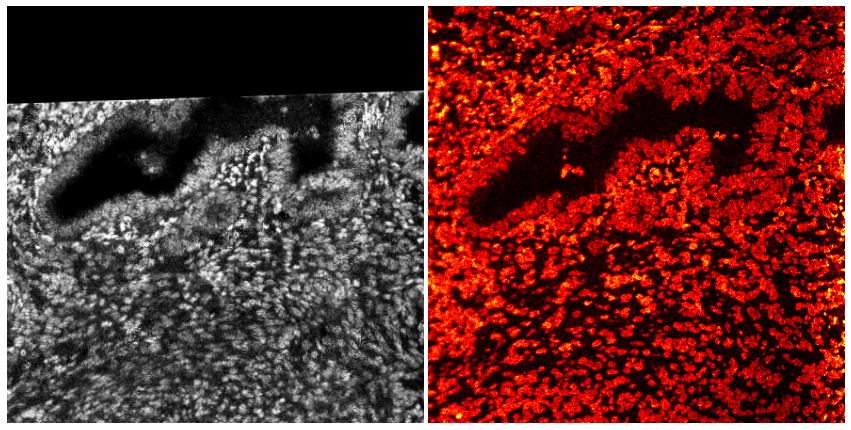

In [114]:
for i in range(len(imgs_h3_r_crop)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(imgs_h3_r_t_crop[i], cmap="gray")
    ax[1].imshow(imgs_nuclei_downscale[i], cmap="hot")
    ax[0].axis("off")
    ax[1].axis("off")
    fig.subplots_adjust(wspace=0.01)
    plt.show()

In [121]:
# match_info_dir = p_dir / "data" / "match"

# for i, dataset in enumerate(datasets):
#     info = {
#         "rotation_init": rotation + rotations[i],
#         "rotation_adjust": 0,
#         "bbox": bboxs_r[i],
#         "bbox_aff": bboxs_r_t[i],
#         "pad": pad,
#         "dim": fovs[i],
#         "border": border,
#         "affine": affs[i]
#     }
#     my_utils.save_pkl(match_info_dir / f"{experiment}_{dataset}.pickle", info)
#     break